In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
df_merged = pd.read_csv("../data/merged_datasetes_balanced_huge.csv")

In [4]:
df_merged.shape

(40000, 2)

## Text cleaning 

#### Text Cleaning is also optional and some kind of hyperparameter

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+',b'',text)
    text = re.sub('[%s]' % re.escape(string.punctuation),'',text)
    text = re.sub('\w*\d\w*','',text)
    return text

In [6]:
df_merged['title'] = df_merged['title'].apply(clean_text)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    df_merged["title"], 
    df_merged["clickbait"],
    test_size=0.2, 
    random_state=42
)

## Fitting TFIDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer()
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

## Trivial model without any library

In [9]:
mask = y_train.astype(bool).values

In [10]:
mask[:100]

array([False, False, False, False,  True, False,  True,  True, False,
        True,  True, False, False,  True, False,  True, False,  True,
        True, False,  True,  True, False,  True,  True,  True, False,
       False,  True, False, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False,  True,
        True, False, False, False,  True,  True,  True,  True,  True,
        True, False, False, False,  True, False,  True,  True,  True,
       False,  True, False,  True, False,  True, False, False, False,
        True, False, False, False,  True, False,  True,  True, False,
        True,  True, False, False, False, False,  True, False,  True,
        True, False, False, False, False, False, False, False, False,
       False])

In [11]:
fake_news_centroid = np.array(xv_train[mask].mean(axis=0)).ravel()
no_fake_news_centroid = np.array(xv_train[~mask].mean(axis=0)).ravel()

In [12]:
xv_train.shape

(32000, 24849)

In [13]:
fake_news_centroid.shape

(24849,)

In [14]:
no_fake_news_centroid.shape

(24849,)

In [15]:
fake_news_score = xv_test.dot(fake_news_centroid-no_fake_news_centroid)
fake_news_score.round(2)

array([ 0.  , -0.  ,  0.  , ..., -0.  , -0.  ,  0.01])

In [16]:
from sklearn.preprocessing import MinMaxScaler

x_test_df = pd.DataFrame(x_test)
print(x_test_df.shape)
x_test_df['clickbait'] = y_test
x_test_df['clickbait_score_model'] = MinMaxScaler().fit_transform(fake_news_score.reshape(-1,1))
x_test_df['clickbait_prediction'] = (x_test_df.clickbait_score_model > 0.3).astype(int)

(8000, 1)


In [17]:
x_test_df

,title,clickbait,clickbait_score_model,clickbait_prediction
32823,billboard s top most popular holiday songs,1,0.247732,0
16298,watch live state department briefing,0,0.168534,0
28505,restaurant prints pro immigrant note at the bo...,1,0.242766,0
6689,same sex marriage laws pose protection quandary,0,0.197095,0
26893,star wars the last jedi trailer what does ...,1,0.404926,1
...,...,...,...,...
13618,fan ordered to destroy cds,0,0.192336,0
35165,people got tested to see what their actual eth...,1,0.396457,1
16359,nicolaus copernicus buried again,0,0.173834,0
3842,the week in finance us banks jump on deregula...,0,0.174941,0


In [18]:
predictions = x_test_df.clickbait_prediction

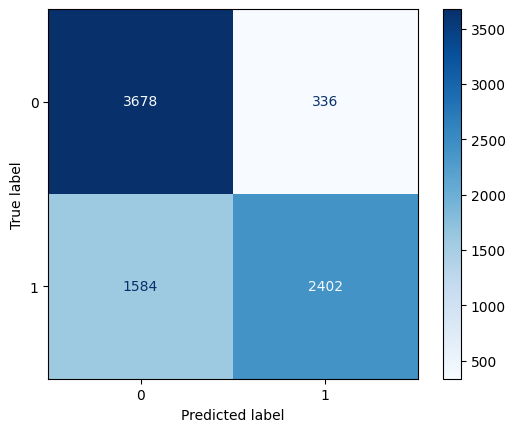

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [20]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.70      0.92      0.79      4014
           1       0.88      0.60      0.71      3986

    accuracy                           0.76      8000
   macro avg       0.79      0.76      0.75      8000
weighted avg       0.79      0.76      0.75      8000

